## Multi-Objective Meta-Optimization

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/MetaOps) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsl1877BS8m3yt8t_wq2IWji)

## Introduction

In the [previous paper](https://github.com/Hvass-Labs/MetaOps/blob/master/01_Bayesian_Meta-Optimization.ipynb) we saw how we could tune the parameters of heuristic optimizers such as Genetic Algorithms (GA), Particle Swarm Optimization (PSO) and Differential Evolution (DE) to perform well on a given problem. We did this by using another overlaying optimizer. This is often called [Meta-Optimization](https://en.wikipedia.org/wiki/Meta-optimization) which is an idea that is closely related to [Hyper-Parameter Optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization).

In the previous paper, we used a so-called Bayesian Optimizer with Gaussian Processes as the meta-optimizer, because it creates an approximation of the meta-fitness landscape, so it only requires a very small number of iterations to find the best parameters.

In this paper we will again tune the parameters of Differential Evolution (DE) but instead of considering just a single performance objective, we now consider two objectives: Its performance on short optimization runs and its performance on long optimization runs. This means there are two conflicting performance measures that we want to tune the parameters for.

It is possible to use a Gaussian Process to approximate these two performance objectives and then use something like the NSGA-2 algorithm to find the so-called Pareto front of parameters that optimally compromise between the two objectives. However, this does not seem to be currently available as open-source. So instead we will just use the NSGA-2 algorithm to directly optimize the two meta-fitness objectives. This is much more time-consuming but it has the benefit of possibly being more accurate, because we do not use an approximation of the meta-fitness landscapes.

In order to speed up the computation, we use a few programming tricks including parallelization.

## Flowchart

The flowchart below shows the rough idea. We use the NSGA-2 algorithm (Non-Dominated Sorting Genetic Algorithm version 2) to propose new parameters for the DE optimizer. We then perform e.g. 32 optimization runs using these parameters and record the mean fitness after 10k and 100k fitness evaluations. These are the two meta-fitness measures that we send back to the NSGA-2 so it can evaluate how well the DE parameters performed and suggest new parameters to be tried. This is repeated until the so-called Pareto optimal front of DE parameters has been found.

![Flowchart](images/02_flowchart_multi-objective.png)

## Imports

In [1]:
# Normal packages.
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
import functools

# Heuristic optimizers such as DE, PSO and NSGA-2.
# This is actually implemented in C++ so it should run very fast.
import pygmo as pg

In [2]:
pg.__version__

'2.8'

## Problem

In this example, the problem that we ultimately want to optimize is the [Rosenbrock](https://en.wikipedia.org/wiki/Rosenbrock_function) benchmark problem in 100 dimensions. You could replace this with your own problem, see the [pygmo manual](https://esa.github.io/pagmo2/docs/python/tutorials/python_tut.html) for instructions.

In [3]:
# Create an instance of the problem we want to optimize.
problem = pg.problem(pg.rosenbrock(dim=100))

In [4]:
# We want to evaluate the performance of DE parameters after
# both 10k and 100k fitness evaluations.
num_fitness_evals1 = 10000
num_fitness_evals2 = 100000

In [5]:
# Number of optimization runs to perform for each new choice
# of parameters for the optimizer. This should not be too low
# because the optimizer is stochastic so we need to average
# out the performance over many runs. But it should not be too high.
# This should be a multiple of number of CPU cores because
# we run it in parallel using all available CPU cores.
num_runs = 32

## Optimizer Parameters

In this example, we will use [Differential Evolution (DE)](https://en.wikipedia.org/wiki/Differential_evolution) as the heuristic optimizer whose parameters we want to tune. We first need to setup the search-space dimensions for the parameters. We will use the NSGA-2 implementation from Pygmo as the meta-optimizer, which requires the search-space to be defined as floating-point arrays.

In [6]:
# Names for the parameters.
# This is actually not used in the code below, but is merely
# included here as a reminder of the dimensions.
dimension_names = ["pop_size", "F", "CR", "variant"]

In [7]:
# Lower and upper boundaries for the parameters.
params_min = [5.0, 0.0, 0.0, 1.0]
params_max = [200.0, 1.0, 1.0, 10.0]

In [8]:
# A default choice of parameters.
default_parameters = [100, 0.8, 0.9, 2]

In [9]:
def unpack_parameters(params):
    """
    Unpack an array of floats to the individual parameters
    of the proper type. Note that the parameters CR and F
    are rounded to 2 decimals, which works together with
    the meta_fitness() function and its decorator @lru_cache
    as explained further below.
    """

    pop_size = int(params[0] + 0.5)     # int
    CR = round(params[1], 2)            # float with 2 decimals
    F = round(params[2], 2)             # float with 2 decimals
    variant = int(params[3] + 0.5)      # int
    
    return pop_size, CR, F, variant

In [10]:
# Names of the optimizer variants used for printing.
variant_names = \
{
     1: "best/1/exp",
     2: "rand/1/exp",
     3: "rand-to-best/1/exp",
     4: "best/2/exp",
     5: "rand/2/exp",
     6: "best/1/bin",
     7: "rand/1/bin",
     8: "rand-to-best/1/bin",
     9: "best/2/bin",
     10: "rand/2/bin"    
}

## Parallel Optimization Runs

Calculating the meta-fitness requires us to perform a number of optimization runs on the Rosenbrock problem and average the best-found fitness values from those runs. To speed up the execution we perform these optimization runs in parallel.

This could have been implemented more elegantly using a function `parallel_run()` with a sub-function `_single_run()` but that did not seem to work.

In [11]:
class ParallelRunner:
    """Perform a number of optimization runs in parallel."""
    
    def __init__(self, num_generations, pop_size, CR, F, variant):
        # Copy parameters for optimizer.
        self.num_generations = num_generations
        self.pop_size = pop_size
        self.CR = CR
        self.F = F
        self.variant = variant

    def _single_run(self, i):
        """
        Perform a single optimization run and return the best fitness.
        
        :param i: Parallel job number. Ignored here.
        :return: Best fitness found.
        """

        # Create a new instance of the optimizer using
        # the given parameters.
        uda = pg.de(gen=self.num_generations,
                    CR=self.CR, F=self.F, variant=self.variant)
        optimizer = pg.algorithm(uda=uda)

        # Create a population of agents for the optimizer.
        population = pg.population(problem, size=self.pop_size)

        # Evolve the optimizer's population.
        population = optimizer.evolve(population)

        # Best fitness found in this optimization run.
        fitness = population.champion_f[0]

        return fitness

    def run(self):
        """Perform the optimization runs in parallel."""

        # Create a pool of workers sized according to the CPU cores available.
        pool = mp.Pool()

        # Calculate the fitness for each agent in parallel.
        fitnesses = pool.map(self._single_run, range(num_runs))

        # Close the pool of workers and wait for them all to finish.
        pool.close()
        pool.join()
        
        return fitnesses

## Meta-Fitness

The meta-fitness function performs a number of optimization runs with the given choice of parameters and evaluates their performance.

In [12]:
@functools.lru_cache()
def meta_fitness(pop_size, CR, F, variant):
    """
    Meta-fitness for evaluating multiple performance objectives
    of the optimizer when run e.g. on the Rosenbrock problem.

    Note the function-decorator @functools.lru_cache which
    caches the results of previous calls to this function.
    This is because the NSGA-2 meta-optimizer calls this
    function with identical parameters many times, and although
    the result is stochastic so it may improve slightly, it
    wastes a lot of computation to calculate very similar
    meta-fitness values for identical parameters. By using cached
    results we save about 80% of the computation time.
    To effectively use the caching, the parameters pop_size and
    variant are integers and the parameters CR and F have been
    rounded to 2 decimals in the unpack_parameters() function.

    :param pop_size: Population size.
    :param CR: Control-parameter CR (crossover probability).
    :param F: Control-parameter F (differential weight).
    :param variant: DE variant, integer between 1 and 10.
    :return: (meta_fitness1, meta_fitness2)
    """

    def _run(num_generations):
        """Helper-function for performing optimization runs."""

        # Create the job-runner for doing the optimization runs.
        runner = ParallelRunner(num_generations=num_generations,
                                pop_size=pop_size,
                                CR=CR, F=F, variant=variant)
        
        # Perform the optimization runs in parallel.
        # This returns a list of the best fitness-values found
        # for each of the optimization runs.
        fitnesses = runner.run()
        
        # The meta-fitness measure of how well the optimizer
        # performed with those parameters, averaged over
        # several optimization runs.
        meta_fitness = np.mean(fitnesses)
        
        return meta_fitness

    # Print parameters.
    print("pop_size:", pop_size)
    print("CR: {0:.2f}".format(CR))
    print("F: {0:.2f}".format(F))
    print("variant: {0} ({1})".format(variant,
                                      variant_names[variant]))
    
    # Number of iterations for the optimizer's population.
    # This ensures that we perform the same number of
    # evaluations of the problem's fitness function
    # regardless of the population-size.
    num_generations1 = num_fitness_evals1 // pop_size
    num_generations2 = num_fitness_evals2 // pop_size
        
    # Note that we execute separate optimization runs for both
    # num_generations1 and num_generations2. We could of course
    # just have used the intermediate fitness-values from a
    # single run. But this was easier to implement with Pygmo
    # although it wastes a bit of computation. 

    # Perform the optimization runs and get their meta-fitness.
    meta_fitness1 = _run(num_generations1)
    meta_fitness2 = _run(num_generations2)

    # Print the meta-fitness.
    print("meta_fitness1: {0:.2e}".format(meta_fitness1))
    print("meta_fitness2: {0:.2e}".format(meta_fitness2))
    print()

    # Return a multi-objective meta-fitness value.
    return [meta_fitness1, meta_fitness2]

## Meta-Optimizer

We use NSGA-2 as the meta-optimizer for tuning the parameters of the DE algorithm so as to perform well on the two meta-fitness measures we defined above.

In order to get this working in Pygmo, we first need to wrap the above `meta_fitness()` function in this `MetaProblem` class that is compatible with Pygmo.

In [13]:
class MetaProblem:
    """
    Wrapper for the meta_fitness() function that connects it with
    the meta-optimizer. This is necessary when using the pygmo API.
    """

    def __init__(self):
        pass

    def fitness(self, params):
        """
        Calculate and return the meta-fitness values for
        the given parameters.
        """

        # Unpack the parameters.
        pop_size, CR, F, variant = unpack_parameters(params)
        
        # Calculate and return the meta-fitness values.
        return meta_fitness(pop_size=pop_size,
                            CR=CR, F=F, variant=variant)

    def get_bounds(self):
        """Get boundaries of the parameter search-space."""
        return params_min, params_max

    def get_nobj(self):
        """Get number of meta-fitness-objectives."""
        return 2

This is the function for doing the actual meta-optimization. It creates an instance of the `MetaProblem` class we just defined, and then runs NSGA-2 on it.

In [14]:
def meta_optimize(pop_size=40, num_generations=100):
    """
    Perform multi-objective meta-optimization using NSGA-2
    to find the best parameters of DE with regard to the
    two meta-fitness measures defined above.
    
    :param pop_size: Population size for NSGA-2.
    :param num_generations: Number of generations to run NSGA-2.
    :return: (best_meta_fitness: 2-dim numpy array,
              best_parameters: 2-dim numpy array)
    """

    # Create the meta-problem-instance.
    meta_problem = MetaProblem()

    # Create an NSGA-2 Multi-Objective meta-optimizer.
    optimizer = pg.algorithm(uda=pg.nsga2(gen=num_generations))
    
    # Create a population of candidate parameters for DE.
    population = pg.population(prob=meta_problem, size=pop_size)
    
    # Perform meta-optimization of DE parameters.
    population = optimizer.evolve(population)

    # Get the best-found parameters and meta-fitnesses.
    best_parameters = population.get_x()
    best_meta_fitness = population.get_f()

    # Sorted index for the meta-fitnesses.
    idx_sort = np.argsort(best_meta_fitness[:, 0])

    # Sort the best-found parameters and meta-fitnesses.
    best_parameters = best_parameters[idx_sort]
    best_meta_fitness = best_meta_fitness[idx_sort]
    
    return best_meta_fitness, best_parameters

## Run Meta-Optimization

We can now run the meta-optimization. Depending on all the settings as well as the speed and number of CPU cores of your computer, this may take minutes or hours to run.

In [15]:
%%time
best_meta_fitness, best_parameters = \
    meta_optimize(pop_size=40, num_generations=100)

pop_size: 108
CR: 0.48
F: 0.25
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.73e+06
meta_fitness2: 1.70e+03

pop_size: 33
CR: 0.76
F: 0.51
variant: 5 (rand/2/exp)
meta_fitness1: 1.13e+05
meta_fitness2: 9.42e+01

pop_size: 19
CR: 0.18
F: 0.60
variant: 2 (rand/1/exp)
meta_fitness1: 2.28e+04
meta_fitness2: 1.83e+02

pop_size: 93
CR: 0.93
F: 0.03
variant: 4 (best/2/exp)
meta_fitness1: 6.66e+05
meta_fitness2: 6.66e+05

pop_size: 193
CR: 0.42
F: 0.46
variant: 7 (rand/1/bin)
meta_fitness1: 1.20e+06
meta_fitness2: 3.00e+04

pop_size: 38
CR: 0.75
F: 0.71
variant: 7 (rand/1/bin)
meta_fitness1: 1.51e+06
meta_fitness2: 3.29e+04

pop_size: 22
CR: 0.09
F: 0.38
variant: 9 (best/2/bin)
meta_fitness1: 1.51e+03
meta_fitness2: 2.04e+02

pop_size: 151
CR: 0.63
F: 0.77
variant: 9 (best/2/bin)
meta_fitness1: 3.29e+06
meta_fitness2: 2.17e+06

pop_size: 153
CR: 0.03
F: 0.78
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 4.01e+06
meta_fitness2: 9.19e+03

pop_size: 70
CR: 0.29
F: 0.83
variant: 9 (best/2/bin)

meta_fitness1: 1.21e+06
meta_fitness2: 4.35e+03

pop_size: 56
CR: 0.40
F: 0.13
variant: 8 (rand-to-best/1/bin)
meta_fitness1: 1.59e+05
meta_fitness2: 1.58e+05

pop_size: 22
CR: 0.36
F: 0.65
variant: 4 (best/2/exp)
meta_fitness1: 4.34e+04
meta_fitness2: 1.42e+02

pop_size: 22
CR: 0.09
F: 0.37
variant: 9 (best/2/bin)
meta_fitness1: 1.62e+03
meta_fitness2: 2.30e+02

pop_size: 22
CR: 0.08
F: 0.78
variant: 9 (best/2/bin)
meta_fitness1: 2.71e+05
meta_fitness2: 1.40e+03

pop_size: 33
CR: 0.76
F: 0.65
variant: 5 (rand/2/exp)
meta_fitness1: 2.20e+05
meta_fitness2: 9.86e+01

pop_size: 55
CR: 0.35
F: 0.51
variant: 8 (rand-to-best/1/bin)
meta_fitness1: 5.93e+03
meta_fitness2: 2.69e+03

pop_size: 23
CR: 0.10
F: 0.38
variant: 9 (best/2/bin)
meta_fitness1: 1.48e+03
meta_fitness2: 2.08e+02

pop_size: 52
CR: 0.22
F: 0.24
variant: 8 (rand-to-best/1/bin)
meta_fitness1: 6.79e+04
meta_fitness2: 6.53e+04

pop_size: 54
CR: 0.18
F: 0.65
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 9.71e+05
meta_fitness2: 3.

meta_fitness1: 1.98e+03
meta_fitness2: 1.00e+02

pop_size: 19
CR: 0.46
F: 0.47
variant: 2 (rand/1/exp)
meta_fitness1: 6.08e+03
meta_fitness2: 1.17e+02

pop_size: 17
CR: 0.23
F: 0.24
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.58e+05
meta_fitness2: 2.67e+02

pop_size: 25
CR: 0.19
F: 0.26
variant: 8 (rand-to-best/1/bin)
meta_fitness1: 1.25e+05
meta_fitness2: 1.25e+05

pop_size: 23
CR: 0.48
F: 0.62
variant: 2 (rand/1/exp)
meta_fitness1: 2.71e+04
meta_fitness2: 9.61e+01

pop_size: 23
CR: 0.41
F: 0.70
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 3.09e+04
meta_fitness2: 1.20e+02

pop_size: 25
CR: 0.92
F: 0.46
variant: 1 (best/1/exp)
meta_fitness1: 9.81e+03
meta_fitness2: 5.79e+02

pop_size: 22
CR: 0.52
F: 0.20
variant: 2 (rand/1/exp)
meta_fitness1: 4.50e+03
meta_fitness2: 1.66e+02

pop_size: 22
CR: 0.07
F: 0.51
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.20e+05
meta_fitness2: 1.91e+00

pop_size: 27
CR: 0.49
F: 0.26
variant: 2 (rand/1/exp)
meta_fitness1: 1.46e+04
meta_fitness2: 1.

meta_fitness1: 6.69e+03
meta_fitness2: 2.64e+01

pop_size: 25
CR: 0.94
F: 0.70
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.81e+03
meta_fitness2: 7.71e+01

pop_size: 25
CR: 0.37
F: 0.72
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 5.41e+04
meta_fitness2: 1.17e+02

pop_size: 17
CR: 0.97
F: 0.46
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 3.81e+05
meta_fitness2: 3.75e+05

pop_size: 19
CR: 0.88
F: 0.69
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.20e+03
meta_fitness2: 1.01e+02

pop_size: 25
CR: 0.12
F: 0.25
variant: 2 (rand/1/exp)
meta_fitness1: 4.23e+04
meta_fitness2: 6.03e+01

pop_size: 25
CR: 0.45
F: 0.71
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 4.15e+04
meta_fitness2: 1.27e+02

pop_size: 17
CR: 0.89
F: 0.47
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.62e+04
meta_fitness2: 1.89e+04

pop_size: 19
CR: 0.16
F: 0.22
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 4.72e+05
meta_fitness2: 1.01e+02

pop_size: 19
CR: 0.18
F: 0.49
variant: 2 (rand/1/exp)
meta_fitness1: 2.

meta_fitness1: 2.60e+04
meta_fitness2: 2.00e+02

pop_size: 19
CR: 0.19
F: 0.49
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 4.38e+04
meta_fitness2: 4.78e+00

pop_size: 19
CR: 0.18
F: 0.22
variant: 8 (rand-to-best/1/bin)
meta_fitness1: 1.85e+05
meta_fitness2: 1.85e+05

pop_size: 19
CR: 0.16
F: 0.66
variant: 2 (rand/1/exp)
meta_fitness1: 2.72e+04
meta_fitness2: 2.26e+02

pop_size: 19
CR: 0.11
F: 0.49
variant: 2 (rand/1/exp)
meta_fitness1: 2.62e+04
meta_fitness2: 1.60e+02

pop_size: 19
CR: 0.17
F: 0.24
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 3.75e+05
meta_fitness2: 1.31e+02

pop_size: 17
CR: 0.15
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.18e+04
meta_fitness2: 2.89e+01

pop_size: 10
CR: 0.17
F: 0.47
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 4.66e+03
meta_fitness2: 3.18e+01

pop_size: 19
CR: 0.18
F: 0.49
variant: 8 (rand-to-best/1/bin)
meta_fitness1: 2.10e+04
meta_fitness2: 1.87e+04

pop_size: 19
CR: 0.20
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 3.

meta_fitness1: 2.50e+05
meta_fitness2: 1.19e+05

pop_size: 17
CR: 0.18
F: 0.42
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 5.60e+04
meta_fitness2: 2.69e+00

pop_size: 19
CR: 0.91
F: 0.67
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.39e+03
meta_fitness2: 1.87e+02

pop_size: 19
CR: 0.18
F: 0.50
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 4.07e+04
meta_fitness2: 1.53e+00

pop_size: 19
CR: 0.15
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 3.43e+04
meta_fitness2: 3.95e+01

pop_size: 10
CR: 0.14
F: 0.64
variant: 8 (rand-to-best/1/bin)
meta_fitness1: 7.68e+03
meta_fitness2: 1.11e+03

pop_size: 10
CR: 0.18
F: 0.50
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 3.28e+03
meta_fitness2: 2.26e+01

pop_size: 19
CR: 0.13
F: 0.71
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 4.52e+04
meta_fitness2: 9.92e+01

pop_size: 19
CR: 0.19
F: 0.64
variant: 7 (rand/1/bin)
meta_fitness1: 7.04e+04
meta_fitness2: 9.98e+01

pop_size: 19
CR: 0.19
F: 0.64
variant: 8 (rand-to-best/1/bin)
meta_fitn

meta_fitness1: 1.93e+04
meta_fitness2: 1.05e+02

pop_size: 10
CR: 0.91
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.92e+04
meta_fitness2: 7.62e+03

pop_size: 55
CR: 0.14
F: 0.47
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.38e+06
meta_fitness2: 1.27e+02

pop_size: 10
CR: 0.18
F: 0.64
variant: 8 (rand-to-best/1/bin)
meta_fitness1: 1.50e+04
meta_fitness2: 2.83e+03

pop_size: 19
CR: 0.21
F: 0.71
variant: 8 (rand-to-best/1/bin)
meta_fitness1: 1.18e+03
meta_fitness2: 1.02e+02

pop_size: 19
CR: 0.86
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 8.75e+02
meta_fitness2: 1.27e+02

pop_size: 19
CR: 0.44
F: 0.46
variant: 8 (rand-to-best/1/bin)
meta_fitness1: 2.14e+05
meta_fitness2: 2.12e+05

pop_size: 17
CR: 0.19
F: 0.65
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.98e+04
meta_fitness2: 7.15e+01

pop_size: 19
CR: 0.15
F: 0.63
variant: 7 (rand/1/bin)
meta_fitness1: 3.42e+04
meta_fitness2: 9.55e+01

pop_size: 9
CR: 0.13
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitne

meta_fitness1: 3.80e+04
meta_fitness2: 1.29e+02

pop_size: 51
CR: 0.19
F: 0.65
variant: 8 (rand-to-best/1/bin)
meta_fitness1: 2.35e+04
meta_fitness2: 1.08e+02

pop_size: 12
CR: 0.18
F: 0.64
variant: 4 (best/2/exp)
meta_fitness1: 6.68e+03
meta_fitness2: 1.79e+02

pop_size: 10
CR: 0.20
F: 0.71
variant: 7 (rand/1/bin)
meta_fitness1: 3.01e+04
meta_fitness2: 9.44e+01

pop_size: 17
CR: 0.15
F: 0.64
variant: 7 (rand/1/bin)
meta_fitness1: 3.31e+04
meta_fitness2: 9.62e+01

pop_size: 19
CR: 0.18
F: 0.46
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 5.89e+04
meta_fitness2: 9.55e-01

pop_size: 17
CR: 0.41
F: 0.65
variant: 8 (rand-to-best/1/bin)
meta_fitness1: 6.59e+03
meta_fitness2: 2.37e+02

pop_size: 9
CR: 0.42
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 6.68e+02
meta_fitness2: 1.27e+02

pop_size: 10
CR: 0.13
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.69e+03
meta_fitness2: 5.34e+01

pop_size: 19
CR: 0.14
F: 0.63
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 3.16e+04
me

meta_fitness1: 9.97e+03
meta_fitness2: 1.12e+01

pop_size: 10
CR: 0.18
F: 0.63
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.01e+03
meta_fitness2: 3.13e+01

pop_size: 17
CR: 0.38
F: 0.47
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.19e+04
meta_fitness2: 4.25e+00

pop_size: 11
CR: 0.39
F: 0.63
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.38e+03
meta_fitness2: 1.22e+02

pop_size: 17
CR: 0.23
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.59e+04
meta_fitness2: 5.00e+01

pop_size: 10
CR: 0.42
F: 0.48
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.15e+03
meta_fitness2: 2.71e+02

pop_size: 10
CR: 0.15
F: 0.63
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.31e+03
meta_fitness2: 4.50e+01

pop_size: 17
CR: 0.42
F: 0.47
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 9.11e+03
meta_fitness2: 8.83e+00

pop_size: 17
CR: 0.20
F: 0.46
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 3.45e+04
meta_fitness2: 2.64e-01

pop_size: 16
CR: 0.19
F: 0.47
variant: 3 (rand-to-best/1/exp)
m

meta_fitness1: 3.71e+03
meta_fitness2: 1.33e+02

pop_size: 9
CR: 0.20
F: 0.71
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.40e+03
meta_fitness2: 9.71e+01

pop_size: 16
CR: 0.13
F: 0.60
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.18e+04
meta_fitness2: 4.96e+00

pop_size: 10
CR: 0.10
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.70e+03
meta_fitness2: 1.17e+01

pop_size: 10
CR: 0.37
F: 0.62
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.02e+03
meta_fitness2: 1.29e+02

pop_size: 6
CR: 0.18
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.12e+03
meta_fitness2: 3.94e+02

pop_size: 9
CR: 0.12
F: 0.62
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.09e+03
meta_fitness2: 4.11e+01

pop_size: 10
CR: 0.43
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 9.14e+02
meta_fitness2: 1.61e+02

pop_size: 13
CR: 0.19
F: 0.47
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.12e+04
meta_fitness2: 6.87e+00

pop_size: 10
CR: 0.40
F: 0.60
variant: 3 (rand-to-best/1/exp)
meta

meta_fitness1: 1.72e+03
meta_fitness2: 4.73e+01

pop_size: 10
CR: 0.20
F: 0.66
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.93e+03
meta_fitness2: 5.56e+01

pop_size: 14
CR: 0.13
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 9.20e+03
meta_fitness2: 1.99e+01

pop_size: 9
CR: 0.19
F: 0.63
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.42e+03
meta_fitness2: 1.88e+01

pop_size: 16
CR: 0.42
F: 0.60
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 4.96e+03
meta_fitness2: 1.04e+02

pop_size: 7
CR: 0.42
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 5.70e+02
meta_fitness2: 1.59e+02

pop_size: 8
CR: 0.20
F: 0.46
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.81e+03
meta_fitness2: 2.10e+02

pop_size: 18
CR: 0.43
F: 0.62
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 7.89e+03
meta_fitness2: 1.17e+02

pop_size: 7
CR: 0.13
F: 0.47
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.46e+03
meta_fitness2: 4.80e+02

pop_size: 11
CR: 0.19
F: 0.46
variant: 3 (rand-to-best/1/exp)
meta_

meta_fitness1: 2.79e+03
meta_fitness2: 2.04e+02

pop_size: 16
CR: 0.20
F: 0.48
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.23e+04
meta_fitness2: 1.91e+00

pop_size: 17
CR: 0.20
F: 0.43
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 4.43e+04
meta_fitness2: 1.90e+00

pop_size: 9
CR: 0.43
F: 0.67
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 8.36e+02
meta_fitness2: 1.30e+02

pop_size: 17
CR: 0.19
F: 0.65
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.98e+04
meta_fitness2: 7.15e+01

pop_size: 7
CR: 0.43
F: 0.45
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.55e+04
meta_fitness2: 1.19e+04

pop_size: 10
CR: 0.43
F: 0.66
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.04e+03
meta_fitness2: 1.43e+02

pop_size: 7
CR: 0.12
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.13e+03
meta_fitness2: 5.55e+01

pop_size: 17
CR: 0.19
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.06e+04
meta_fitness2: 7.02e+01

pop_size: 6
CR: 0.43
F: 0.47
variant: 3 (rand-to-best/1/exp)
meta_

meta_fitness1: 9.23e+02
meta_fitness2: 1.02e+02

pop_size: 16
CR: 0.20
F: 0.45
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 3.13e+04
meta_fitness2: 3.73e+00

pop_size: 14
CR: 0.19
F: 0.65
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 8.11e+03
meta_fitness2: 5.20e+01

pop_size: 7
CR: 0.11
F: 0.47
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 4.97e+03
meta_fitness2: 1.33e+03

pop_size: 10
CR: 0.19
F: 0.62
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.17e+03
meta_fitness2: 1.33e+01

pop_size: 16
CR: 0.13
F: 0.47
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 3.15e+04
meta_fitness2: 1.36e+00

pop_size: 10
CR: 0.17
F: 0.46
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 4.43e+03
meta_fitness2: 9.31e+01

pop_size: 17
CR: 0.45
F: 0.60
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 4.43e+03
meta_fitness2: 1.05e+02

pop_size: 10
CR: 0.18
F: 0.61
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.06e+03
meta_fitness2: 4.17e+01

pop_size: 14
CR: 0.42
F: 0.48
variant: 3 (rand-to-best/1/exp)
me

meta_fitness1: 7.37e+03
meta_fitness2: 2.78e+01

pop_size: 9
CR: 0.41
F: 0.63
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 9.96e+02
meta_fitness2: 1.58e+02

pop_size: 10
CR: 0.21
F: 0.60
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 3.73e+03
meta_fitness2: 5.10e+01

pop_size: 17
CR: 0.20
F: 0.47
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 3.29e+04
meta_fitness2: 2.57e+00

pop_size: 14
CR: 0.18
F: 0.46
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.75e+04
meta_fitness2: 9.12e+00

pop_size: 16
CR: 0.21
F: 0.47
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.00e+04
meta_fitness2: 1.43e+00

pop_size: 10
CR: 0.12
F: 0.62
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.21e+03
meta_fitness2: 2.33e+01

pop_size: 49
CR: 0.42
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 4.37e+05
meta_fitness2: 1.50e+02

pop_size: 7
CR: 0.13
F: 0.62
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.20e+03
meta_fitness2: 2.44e+02

pop_size: 18
CR: 0.23
F: 0.65
variant: 3 (rand-to-best/1/exp)
met

meta_fitness1: 2.89e+03
meta_fitness2: 5.87e+02

pop_size: 14
CR: 0.18
F: 0.62
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 8.47e+03
meta_fitness2: 5.37e+01

pop_size: 9
CR: 0.19
F: 0.47
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.68e+03
meta_fitness2: 5.49e+01

pop_size: 18
CR: 0.20
F: 0.47
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 4.79e+04
meta_fitness2: 6.39e-01

pop_size: 16
CR: 0.43
F: 0.47
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 5.20e+03
meta_fitness2: 2.19e+01

pop_size: 6
CR: 0.11
F: 0.63
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 7.93e+02
meta_fitness2: 1.39e+02

pop_size: 7
CR: 0.20
F: 0.47
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 4.76e+03
meta_fitness2: 3.05e+03

pop_size: 16
CR: 0.42
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 4.36e+03
meta_fitness2: 1.17e+02

pop_size: 7
CR: 0.12
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.10e+03
meta_fitness2: 5.55e+01

pop_size: 7
CR: 0.41
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_f

meta_fitness1: 6.51e+03
meta_fitness2: 1.27e+02

pop_size: 10
CR: 0.11
F: 0.65
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.62e+03
meta_fitness2: 4.76e+00

pop_size: 9
CR: 0.20
F: 0.63
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.53e+03
meta_fitness2: 5.70e+01

pop_size: 7
CR: 0.41
F: 0.71
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 5.65e+02
meta_fitness2: 1.66e+02

pop_size: 7
CR: 0.20
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 8.30e+02
meta_fitness2: 7.17e+01

pop_size: 18
CR: 0.14
F: 0.47
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 5.24e+04
meta_fitness2: 1.34e+00

pop_size: 6
CR: 0.20
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 6.95e+02
meta_fitness2: 1.76e+02

pop_size: 14
CR: 0.20
F: 0.57
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 7.85e+03
meta_fitness2: 5.57e+00

pop_size: 9
CR: 0.45
F: 0.56
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 9.48e+02
meta_fitness2: 1.26e+02

pop_size: 13
CR: 0.18
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_f

meta_fitness1: 2.30e+03
meta_fitness2: 1.24e+02

pop_size: 7
CR: 0.40
F: 0.47
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 5.85e+03
meta_fitness2: 3.28e+03

pop_size: 14
CR: 0.20
F: 0.73
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 7.41e+03
meta_fitness2: 1.28e+02

pop_size: 7
CR: 0.14
F: 0.65
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.02e+03
meta_fitness2: 8.07e+01

pop_size: 16
CR: 0.43
F: 0.62
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 3.49e+03
meta_fitness2: 1.23e+02

pop_size: 10
CR: 0.20
F: 0.46
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 4.46e+03
meta_fitness2: 2.50e+02

pop_size: 17
CR: 0.13
F: 0.62
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.49e+04
meta_fitness2: 7.77e+00

pop_size: 9
CR: 0.22
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.25e+03
meta_fitness2: 7.95e+01

pop_size: 9
CR: 0.42
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 6.71e+02
meta_fitness2: 1.27e+02

pop_size: 9
CR: 0.43
F: 0.70
variant: 3 (rand-to-best/1/exp)
meta_f

meta_fitness1: 7.52e+03
meta_fitness2: 6.06e+01

pop_size: 7
CR: 0.20
F: 0.57
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.08e+03
meta_fitness2: 1.28e+02

pop_size: 13
CR: 0.39
F: 0.72
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.53e+03
meta_fitness2: 1.19e+02

pop_size: 14
CR: 0.10
F: 0.66
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 8.69e+03
meta_fitness2: 3.33e+01

pop_size: 17
CR: 0.14
F: 0.68
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.16e+04
meta_fitness2: 9.22e+01

pop_size: 7
CR: 0.20
F: 0.53
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 3.14e+03
meta_fitness2: 1.64e+03

pop_size: 6
CR: 0.20
F: 0.72
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 7.50e+02
meta_fitness2: 3.58e+02

pop_size: 15
CR: 0.14
F: 0.55
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.62e+04
meta_fitness2: 3.89e+00

pop_size: 17
CR: 0.11
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.91e+04
meta_fitness2: 6.45e+00

pop_size: 7
CR: 0.20
F: 0.46
variant: 3 (rand-to-best/1/exp)
meta_

meta_fitness1: 4.45e+04
meta_fitness2: 1.90e+00

pop_size: 7
CR: 0.14
F: 0.74
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.05e+03
meta_fitness2: 1.03e+02

pop_size: 16
CR: 0.21
F: 0.48
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.12e+04
meta_fitness2: 2.43e+00

pop_size: 9
CR: 0.11
F: 0.61
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.42e+03
meta_fitness2: 7.55e+00

pop_size: 7
CR: 0.10
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.17e+03
meta_fitness2: 8.70e+01

pop_size: 9
CR: 0.20
F: 0.62
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.50e+03
meta_fitness2: 6.52e+00

pop_size: 7
CR: 0.43
F: 0.72
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 5.84e+02
meta_fitness2: 2.11e+02

pop_size: 7
CR: 0.12
F: 0.73
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.02e+03
meta_fitness2: 1.07e+02

pop_size: 10
CR: 0.20
F: 0.47
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 3.07e+03
meta_fitness2: 2.56e+01

pop_size: 14
CR: 0.41
F: 0.73
variant: 3 (rand-to-best/1/exp)
meta_fi

meta_fitness1: 2.20e+04
meta_fitness2: 1.87e+01

pop_size: 7
CR: 0.39
F: 0.76
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 6.01e+02
meta_fitness2: 1.84e+02

pop_size: 7
CR: 0.42
F: 0.73
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 6.52e+02
meta_fitness2: 1.77e+02

pop_size: 13
CR: 0.19
F: 0.47
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.08e+04
meta_fitness2: 6.87e+00

pop_size: 14
CR: 0.11
F: 0.62
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 8.67e+03
meta_fitness2: 8.04e+00

pop_size: 7
CR: 0.11
F: 0.65
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.00e+03
meta_fitness2: 1.23e+02

pop_size: 7
CR: 0.12
F: 0.63
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.14e+03
meta_fitness2: 8.85e+01

pop_size: 14
CR: 0.20
F: 0.46
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.73e+04
meta_fitness2: 5.75e+00

pop_size: 17
CR: 0.20
F: 0.56
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.86e+04
meta_fitness2: 1.42e+01

pop_size: 7
CR: 0.41
F: 0.46
variant: 3 (rand-to-best/1/exp)
meta_f

meta_fitness1: 1.16e+04
meta_fitness2: 8.66e+03

pop_size: 7
CR: 0.11
F: 0.49
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 5.80e+03
meta_fitness2: 8.07e+02

pop_size: 14
CR: 0.19
F: 0.62
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 6.97e+03
meta_fitness2: 3.91e+01

pop_size: 10
CR: 0.38
F: 0.73
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.10e+03
meta_fitness2: 1.48e+02

pop_size: 7
CR: 0.15
F: 0.61
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.13e+03
meta_fitness2: 2.12e+02

pop_size: 7
CR: 0.15
F: 0.47
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 6.09e+03
meta_fitness2: 1.40e+03

pop_size: 17
CR: 0.15
F: 0.46
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 4.17e+04
meta_fitness2: 3.14e+00

pop_size: 7
CR: 0.17
F: 0.73
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 8.14e+02
meta_fitness2: 4.73e+01

pop_size: 16
CR: 0.43
F: 0.47
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 5.16e+03
meta_fitness2: 2.60e+01

pop_size: 9
CR: 0.39
F: 0.63
variant: 3 (rand-to-best/1/exp)
meta_f

meta_fitness1: 8.70e+02
meta_fitness2: 1.36e+02

pop_size: 10
CR: 0.13
F: 0.72
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.54e+03
meta_fitness2: 1.00e+02

pop_size: 7
CR: 0.14
F: 0.62
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.21e+03
meta_fitness2: 3.16e+02

pop_size: 10
CR: 0.15
F: 0.73
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.10e+03
meta_fitness2: 7.03e+01

pop_size: 7
CR: 0.39
F: 0.62
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 9.21e+02
meta_fitness2: 2.65e+02

pop_size: 14
CR: 0.11
F: 0.73
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 9.09e+03
meta_fitness2: 8.41e+01

pop_size: 7
CR: 0.41
F: 0.63
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 8.59e+02
meta_fitness2: 4.56e+02

pop_size: 7
CR: 0.39
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.02e+03
meta_fitness2: 2.19e+02

pop_size: 14
CR: 0.11
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.02e+04
meta_fitness2: 1.14e+01

pop_size: 9
CR: 0.12
F: 0.62
variant: 3 (rand-to-best/1/exp)
meta_f

meta_fitness1: 2.23e+04
meta_fitness2: 7.03e+00

pop_size: 10
CR: 0.19
F: 0.62
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.17e+03
meta_fitness2: 1.33e+01

pop_size: 10
CR: 0.15
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.48e+03
meta_fitness2: 3.97e+01

pop_size: 14
CR: 0.19
F: 0.56
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 9.58e+03
meta_fitness2: 3.34e+00

pop_size: 14
CR: 0.18
F: 0.56
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.14e+04
meta_fitness2: 9.57e+00

pop_size: 5
CR: 0.41
F: 0.47
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.33e+04
meta_fitness2: 2.19e+04

pop_size: 16
CR: 0.20
F: 0.72
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.27e+04
meta_fitness2: 1.08e+02

pop_size: 17
CR: 0.11
F: 0.65
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 2.86e+04
meta_fitness2: 3.53e+01

pop_size: 10
CR: 0.20
F: 0.46
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 4.46e+03
meta_fitness2: 2.50e+02

pop_size: 8
CR: 0.19
F: 0.47
variant: 3 (rand-to-best/1/exp)
met

meta_fitness1: 2.17e+04
meta_fitness2: 7.74e+01

pop_size: 14
CR: 0.11
F: 0.72
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 8.88e+03
meta_fitness2: 8.57e+01

pop_size: 7
CR: 0.39
F: 0.64
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.03e+03
meta_fitness2: 2.19e+02

pop_size: 17
CR: 0.20
F: 0.60
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.64e+04
meta_fitness2: 4.05e+01

pop_size: 10
CR: 0.13
F: 0.48
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 5.29e+03
meta_fitness2: 2.61e+01

pop_size: 16
CR: 0.12
F: 0.63
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.67e+04
meta_fitness2: 1.51e+01

pop_size: 6
CR: 0.20
F: 0.73
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.50e+03
meta_fitness2: 3.61e+02

pop_size: 17
CR: 0.39
F: 0.46
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 1.17e+04
meta_fitness2: 1.93e+00

pop_size: 13
CR: 0.11
F: 0.63
variant: 3 (rand-to-best/1/exp)
meta_fitness1: 8.06e+03
meta_fitness2: 6.57e+00

pop_size: 14
CR: 0.20
F: 0.55
variant: 3 (rand-to-best/1/exp)
met

## Best Parameters Found

Let us first show the best meta-fitness values we found during meta-optimization. Note how the first column is sorted ascendingly, and the second column is sorted descendingly. This shows the trade-off between the two meta-fitness measures. This is also shown more clearly in the plot of the Pareto front below.

In [16]:
best_meta_fitness

array([[4.83767435e+02, 1.09138896e+02],
       [4.83767435e+02, 1.09138896e+02],
       [5.08789373e+02, 8.45788833e+01],
       [5.08789373e+02, 8.45788833e+01],
       [6.74619826e+02, 7.86115196e+01],
       [6.74619826e+02, 7.86115196e+01],
       [7.63739422e+02, 7.69763487e+01],
       [7.63739422e+02, 7.69763487e+01],
       [7.63739422e+02, 7.69763487e+01],
       [7.76570040e+02, 5.87701076e+01],
       [7.76570040e+02, 5.87701076e+01],
       [8.10502510e+02, 2.01492093e+01],
       [8.10502510e+02, 2.01492093e+01],
       [9.86683735e+02, 1.04225950e+01],
       [9.86683735e+02, 1.04225950e+01],
       [1.33482938e+03, 8.54650743e+00],
       [1.33482938e+03, 8.54650743e+00],
       [1.49784734e+03, 6.77174329e+00],
       [1.49784734e+03, 6.77174329e+00],
       [1.49897889e+03, 6.52229678e+00],
       [1.49897889e+03, 6.52229678e+00],
       [2.09374330e+03, 5.71653451e+00],
       [2.09374330e+03, 5.71653451e+00],
       [2.22243292e+03, 4.33096015e+00],
       [2.222432

We can also print the corresponding parameters for the DE optimizer. These may change each time you run the meta-optimization, but they probably show certain trends e.g. smaller population sizes towards the top, and larger population sizes towards the bottom. This means that shorter optimization runs performed better with smaller population sizes, and vice versa.

In [17]:
[unpack_parameters(params) for params in best_parameters]

[(7, 0.41, 0.73, 3),
 (7, 0.41, 0.73, 3),
 (7, 0.39, 0.73, 3),
 (7, 0.39, 0.73, 3),
 (7, 0.2, 0.72, 3),
 (7, 0.2, 0.72, 3),
 (7, 0.14, 0.72, 3),
 (7, 0.14, 0.72, 3),
 (7, 0.14, 0.72, 3),
 (7, 0.11, 0.64, 3),
 (7, 0.11, 0.64, 3),
 (7, 0.15, 0.64, 3),
 (7, 0.15, 0.64, 3),
 (7, 0.14, 0.64, 3),
 (7, 0.14, 0.64, 3),
 (9, 0.2, 0.64, 3),
 (9, 0.2, 0.64, 3),
 (9, 0.2, 0.62, 3),
 (9, 0.2, 0.62, 3),
 (9, 0.2, 0.62, 3),
 (9, 0.2, 0.62, 3),
 (9, 0.11, 0.62, 3),
 (9, 0.11, 0.62, 3),
 (10, 0.17, 0.64, 3),
 (10, 0.17, 0.64, 3),
 (10, 0.11, 0.64, 3),
 (10, 0.11, 0.64, 3),
 (10, 0.13, 0.62, 3),
 (10, 0.13, 0.62, 3),
 (14, 0.2, 0.56, 3),
 (14, 0.2, 0.56, 3),
 (14, 0.2, 0.56, 3),
 (14, 0.11, 0.63, 3),
 (14, 0.11, 0.63, 3),
 (14, 0.19, 0.47, 3),
 (14, 0.19, 0.47, 3),
 (16, 0.2, 0.47, 3),
 (16, 0.2, 0.47, 3),
 (17, 0.2, 0.46, 3),
 (17, 0.2, 0.46, 3)]

## Pareto Front

The so-called Pareto front shows the best solutions found during meta-optimization, which optimally compromise between the two conflicting meta-fitness measures.

In [18]:
def plot_pareto_front():
    """Plot the pareto-front for the meta-fitness values."""

    # Get the meta-fitness-values to plot. These are found
    # by multi-objective optimization so they are on the
    # pareto-front and they are already sorted.
    meta_fitness1 = best_meta_fitness[:, 0]
    meta_fitness2 = best_meta_fitness[:, 1]
    
    # Create a single plot.
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(211)

    # Plot the pareto-front as connected lines.
    ax.plot(meta_fitness1, meta_fitness2)

    # Plot dots to show the exact data-points.
    ax.scatter(meta_fitness1, meta_fitness2)

    # Set title and labels.
    ax.set_title("Pareto Front for Differential Evolution (DE) Parameters")
    ax.set_xlabel("Meta-Fitness 1 (10k steps)")
    ax.set_ylabel("Meta-Fitness 2 (100k steps)")
    
    # Show grid.
    ax.grid()
    
    # Plot with a compact layout.
    plt.tight_layout()
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

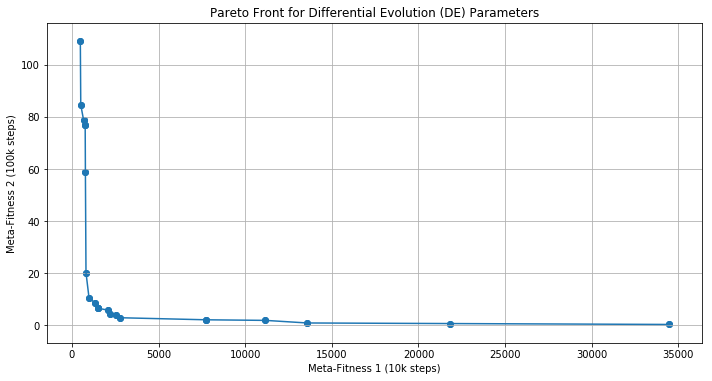

In [19]:
plot_pareto_front()

## Compare Performance

We will now compare the performance of the DE parameters that we found above. We want to compare the two extremes: Using parameters tuned for short runs, and parameters tuned for long runs. We also show a compromise between these two extremes.

The current version of Pygmo has very poor support for logging fitness traces while doing optimization, so this implementation is very awkward and needs several helper-functions.

In [20]:
def multi_fitness_traces(params, num_runs):
    """
    Perform a number of optimization runs with DE using
    the given parameters and return a trace of the mean fitness,
    and the corresponding count of fitness evaluations.
    
    :param params: Array with DE parameters.
    :param num_runs: Number of optimization runs.
    :return: (trace_mean: 1-d numpy array,
              steps: 1-d numpy array)
    """
    
    # Unpack the DE parameters.
    pop_size, CR, F, variant = \
        unpack_parameters(params=params)
    
    # The number of generations to evaluate.
    num_generations = num_fitness_evals2 // pop_size
    
    def _single_fitness_trace():
        """Helper-function for doing a single optimization run."""

        # Create a new instance of the optimizer using
        # the given parameters. ftol and xtol are set to zero
        # so it does not abort the optimization upon convergence.
        # This is necessary so we get the same log-size for all runs.
        uda = pg.de(gen=num_generations,
                    CR=CR, F=F, variant=variant,
                    ftol=0.0, xtol=0.0)
        optimizer = pg.algorithm(uda=uda)

        # Set the optimizer to log after each GENERATION!
        # This means we perform pop_size fitness evaluations
        # between each entry in the log, which is why we
        # cannot compare the logs directly for different parameters.
        optimizer.set_verbosity(level=1)

        # Create a population of agents for the optimizer.
        population = pg.population(prob=problem, size=pop_size)

        # Evolve the optimizer's population.
        population = optimizer.evolve(population)

        # Get the fitness-log from the optimizer using
        # some extremely weird API calls in Pygmo.
        uda = optimizer.extract(pg.de)
        log = np.array(uda.get_log())
        fitness_trace = log[:, 2]

        # Return the fitness trace for this run.
        return fitness_trace 

    # Perform the given number of optimization runs and
    # get their fitness traces as a 2-dim array.
    fitness_traces = [_single_fitness_trace()
                      for i in range(num_runs)]
    
    # Convert to a numpy array so it is easier to work with.
    fitness_traces = np.array(fitness_traces)
    
    # Take the average fitness-trace for all optimization runs.
    trace_mean = fitness_traces.mean(axis=0)

    # Calculate the number of steps (or fitness evaluations)
    # corresponding to the entries in the trace. This is necessary
    # to compare the fitness traces for different pop_size,
    # because the fitness trace is logged after each GENERATION
    # of the entire population, rather than after each
    # fitness evaluation.
    steps = np.arange(len(trace_mean)) * pop_size

    return trace_mean, steps

In [21]:
def plot_fitness_traces(num_runs=50):
    """
    Perform the given number of optimization runs with
    different choices of parameters for the DE optimizer
    and plot their fitness-traces for comparison.
    """

    # Create a single plot.
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(211)

    # Fitness-trace for parameters tuned for SHORT runs.
    trace1, steps1 = \
        multi_fitness_traces(params=best_parameters[0],
                             num_runs=num_runs)

    # Fitness-trace for compromise parameters.
    idx_compromise = len(best_parameters) // 2
    trace2, steps2 = \
        multi_fitness_traces(params=best_parameters[idx_compromise],
                             num_runs=num_runs)

    # Fitness-trace for parameters tuned for LONG runs.
    trace3, steps3 = \
        multi_fitness_traces(params=best_parameters[-1],
                             num_runs=num_runs)
    
    # Plot the fitness traces.
    ax.plot(steps1, trace1, label="DE Parameters Tuned for SHORT Runs")
    ax.plot(steps2, trace2, label="Compromise Parameters")
    ax.plot(steps3, trace3, label="DE Parameters Tuned for LONG Runs")
    
    # Set y-axis to log-scale.
    ax.set_yscale("log")
    
    # Set plot title and labels.
    ax.set_title("Comparison of DE Parameters")
    ax.set_xlabel("Num. Fitness Evaluations")
    ax.set_ylabel("Rosenbrock Mean Fitness (Log-Scale)")
    
    # Show legend.
    ax.legend()
    
    # Show grid.
    ax.grid()
    
    # Plot with a compact layout.
    plt.tight_layout()
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

We can now plot the comparison of fitness-traces over 50 optimization runs with different choices of parameters for DE. This shows that the parameters work as intended. The parameters tuned for short runs perform best in the first part of the optimization runs, but it ultimately converges to a worse solution than the parameters tuned for long runs, and vice versa. The compromise parameters perform somewhere between these two extremes.

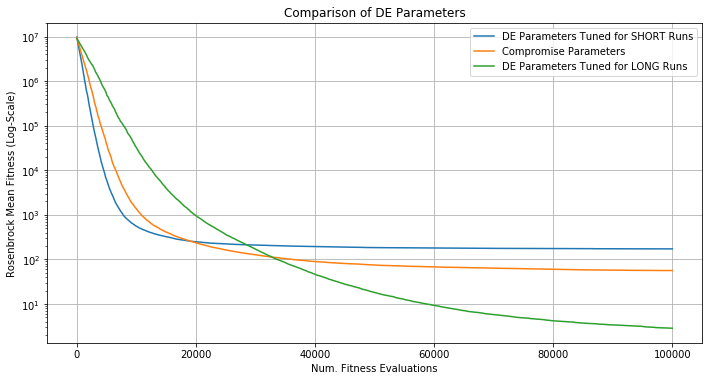

In [22]:
plot_fitness_traces(num_runs=50)

## Conclusion

We have shown how to automatically tune the parameters of a heuristic optimizer for multiple conflicting performance measures. The method was demonstrated on tuning the parameters for short versus long optimization runs, but it should work for any conflicting performance measures.

## Exercises & Research Ideas

There are plenty of opportunities for doing original research using these techniques. Here are some ideas to get you started:

- Try using other benchmark problems as well as real-world problems. Record the results. Are there parameters that seem to work well for all problems?
- Try using multiple problems inside the `meta_fitness()` function. First try and optimize each problem in turn and merely sum the results to an aggregate meta-fitness. Then try and use individual objectives for each problem.
- Try running more iterations of the meta-optimizer. Does that improve the results?
- Tune the parameters of another optimizer such as Particle Swarm Optimization (PSO) or Genetic Algorithm (GA).
- Can you eliminate some of the optimizer's parameters if they are irrelevant? Can you simplify the algorithm as a result? How does it perform on a broad range of problems?

## License (MIT)

Copyright (c) 2018 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.